# Predicting Fraudulent Credit Card Transaction with NN

Inspiration  
Identify fraudulent credit card transactions.  
https://www.kaggle.com/mlg-ulb/creditcardfraud/home


In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import lightgbm as lgbm

### 0. Load and explore data

#### Data Description 

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Features
Based on data description, we know that v1-v28 are PCA components, they are all numerical variables, so we do not have categorical variables to encode. And here we are going to build a NN, we do not need take care of feature correlation problem (ref). But, NN is very sensitive to feature scaling, here we need normalize the Amount.

In [3]:
data['Normalized_Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time','Amount'],axis=1)

### Class imbalance

As pointed out, the data is highly unbalanced, with only 492 frauds out of 284,807 transactions. 

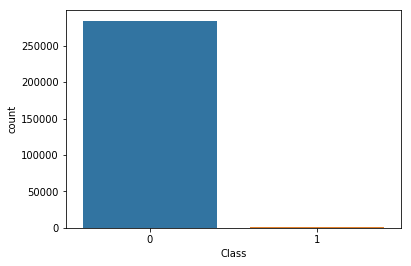

In [4]:
sns.countplot("Class",data=data)

## 1. Define model performance

For such unbalanced classification problem, we need define a proper metric. In this case, we want to detect as many frauds as possible, because for a bank, the cost of identifying a fraud as a normal transaction is very expensive. Therefore, we want use recall, precision or ROUARU intead of accuracy. 

Confusion matrix : also known as the error matrix, allows visualization of the performance of an algorithm :  

true positive (TP) : Diabetic correctly identified as diabetic  
true negative (TN) : Healthy correctly identified as healthy  
false positive (FP) : Healthy incorrectly identified as diabetic  
false negative (FN) : Diabetic incorrectly identified as healthy  

Metrics :  

Accuracy : (TP +TN) / (TP + TN + FP +FN)  
Precision : TP / (TP + FP)  
Recall : TP / (TP + FN)  
F1 score : 2 x ((Precision x Recall) / (Precision + Recall))  

Roc Curve :   

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.



In [5]:
def model_performance(y_test, y_pred) :
    
     # Confusion matrix
    CM = confusion_matrix(y_test, y_pred)
    # Get true positives(tp), false positives(fp), false negatives(fn)
    tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    # Prediction report
    sns.heatmap(CM,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(y_test.values, y_pred))

## 2. Split the data

A common solution for imbalanced classification problem is under sampling or over sampling. Here I tested under sampling, to make the algorithm run faster too. Basically, I choose equall amount of normal transactions as the fraud transactions. 

In [6]:
number_of_fraud = len(data[data.Class == 1])
number_of_normal= len(data[data.Class == 0])

#indices of normal class
indices_of_normal = data[data.Class==0].index
#randomly choose same amount of samples as the fraud, and return their indices
random_indices_of_normal = np.array(np.random.choice(indices_of_normal, number_of_fraud, replace=False))
#indices of fraud class
indices_of_fraud = np.array(data[data.Class == 1].index)
#indices of undersampled dataset
indices_of_undersampled = np.concatenate([random_indices_of_normal, indices_of_fraud])
#undersampled dataset)
data_of_undersampled = data.iloc[indices_of_undersampled,:]

#undersampled dataset
X_undersampled = data_of_undersampled.loc[:,data_of_undersampled.columns!='Class']
y_undersampled = data_of_undersampled.loc[:,data_of_undersampled.columns=='Class']

#train and test dataset splitted from undersampled dataset, with 70/30 ratio
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled,y_undersampled,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train_undersampled))
print("Number transactions test dataset: ", len(X_test_undersampled))

Number transactions train dataset:  688
Number transactions test dataset:  296


## 4. LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:  
Faster training speed and higher efficiency.  
Lower memory usage.  
Better accuracy.  
Support of parallel and GPU learning.  
Capable of handling large-scale data.    
https://lightgbm.readthedocs.io/en/latest/

In [11]:
%%time
clf = lgbm.LGBMClassifier(random_state = 42)
clf.fit(X_train_undersampled, y_train_undersampled.values.ravel())

Wall time: 161 ms


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


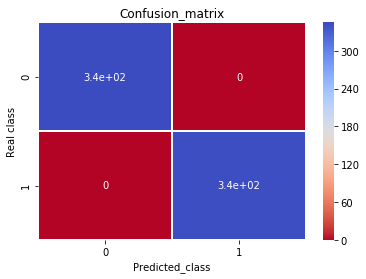


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       345
           1       1.00      1.00      1.00       343

   micro avg       1.00      1.00      1.00       688
   macro avg       1.00      1.00      1.00       688
weighted avg       1.00      1.00      1.00       688



In [12]:
y_train_predict = clf.predict(X_train_undersampled)
model_performance(y_train_undersampled, y_train_predict)

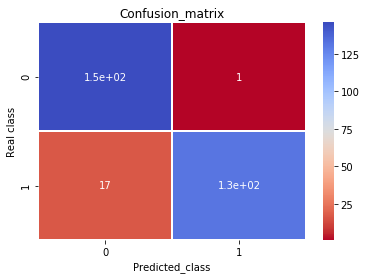


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       147
           1       0.99      0.89      0.94       149

   micro avg       0.94      0.94      0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



In [13]:
y_test_predict = clf.predict(X_test_undersampled)
model_performance(y_test_undersampled, y_test_predict)

## hyperparameter optimization

To find the best hyperparameters, we use random search.  

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html 

important parameters:  
1. num_leaves: This is the main parameter to control the complexity of the tree model.  
2. min_data_in_leaf: This is a very important parameter to prevent over-fitting in a leaf-wise tree.  
3. max_depth: to limit the tree depth explicitly.

For Faster Speed  
Use bagging by setting bagging_fraction and bagging_freq  
Use feature sub-sampling by setting feature_fraction  
Use small max_bin  
Use save_binary to speed up data loading in future learning  
Use parallel learning, refer to Parallel Learning Guide  

For Better Accuracy  
Use large max_bin (may be slower)  
Use small learning_rate with large num_iterations  
Use large num_leaves (may cause over-fitting)  
Use bigger training data  
Try dart  

Deal with Over-fitting  
Use small max_bin  
Use small num_leaves  
Use min_data_in_leaf and min_sum_hessian_in_leaf  
Use bagging by set bagging_fraction and bagging_freq  
Use feature sub-sampling by set feature_fraction  
Use bigger training data  
Try lambda_l1, lambda_l2 and min_gain_to_split for regularization  
Try max_depth to avoid growing deep tree  

In [15]:
help(lgbm.LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(LGBMModel, sklearn.base.ClassifierMixin)
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None)
 |      Build a gradient boosting model from the training set (X, y).
 |      
 |      Parameters
 |      ----------
 |      X : array-like or sparse matrix of shape = [n_samples, n_features]
 |          Input feature matrix.
 |      y : array-like of shape = [n_samples]
 |          The target values (class labels in classification, real numbers in regression).

In [17]:
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 5000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

fit_params = {"early_stopping_rounds" : 50, 
             "eval_metric" : 'binary', 
             "eval_set" : [(X_test_undersampled,y_test_undersampled)],
             'eval_names': ['valid'],
             'verbose': 0 }

In [18]:
help(RandomizedSearchCV)

Help on class RandomizedSearchCV in module sklearn.model_selection._search:

class RandomizedSearchCV(BaseSearchCV)
 |  Randomized search on hyper parameters.
 |  
 |  RandomizedSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated search over parameter settings.
 |  
 |  In contrast to GridSearchCV, not all parameter values are tried out, but
 |  rather a fixed number of parameter settings is sampled from the specified
 |  distributions. The number of parameter settings that are tried is
 |  given by n_iter.
 |  
 |  If all parameters are presented as a list,
 |  sampling without replacement is performed. If at least one parameter
 |  is given as a distribution, sampling with replacement is used.
 |  It is highly recommended

In [30]:
#number of combinations
n_iter = 200 

#intialize lgbm and lunch the search
clf = lgbm.LGBMClassifier(random_state=43, silent=True, metric='None')
grid_search = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='recall',
    cv=5,
    refit=True,
    random_state=43,
    verbose=True)

grid_search.fit(X_train_undersampled, y_train_undersampled.values.ravel(), **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.9097127222982218 with params: {'colsample_bytree': 0.7380735222242458, 'learning_rate': 0.4, 'max_depth': 5, 'min_child_samples': 211, 'min_child_weight': 1e-05, 'n_estimators': 800, 'num_leaves': 49, 'reg_alpha': 1, 'reg_lambda': 50, 'subsample': 0.73223959752976} 


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


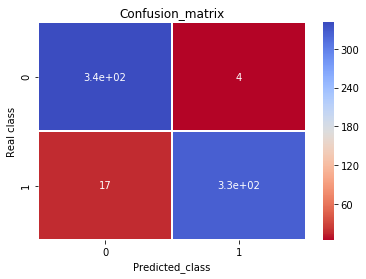


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       345
           1       0.99      0.95      0.97       343

   micro avg       0.97      0.97      0.97       688
   macro avg       0.97      0.97      0.97       688
weighted avg       0.97      0.97      0.97       688



In [32]:
y_train_predict = grid_search.predict(X_train_undersampled)
model_performance(y_train_undersampled, y_train_predict)

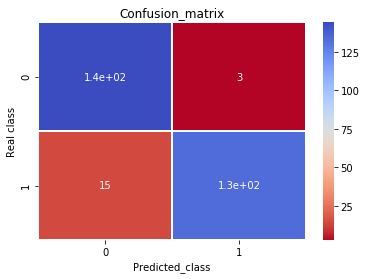


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       147
           1       0.98      0.90      0.94       149

   micro avg       0.94      0.94      0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



In [33]:
y_test_predict = grid_search.predict(X_test_undersampled)
model_performance(y_test_undersampled, y_test_predict)